In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns

In [2]:
BATCH_SIZE = 256
INSTANCE_TYPE = "g5_xlarge"
# DIR = "_TRAIN [1x] g5.xlarge + [1x] m7i.2xlarge/"
DIR = ""

data_s3_1_1 = pd.read_csv(f"{DIR}e2e_training_s3_g5_xlarge_batch_256.csv")
data_s3_1_1.head()

,time_from_start,number_of_rows_finished
0,0.000000,0
1,132.339814,256
2,133.077646,512
3,133.428164,768
4,134.123453,1024


Calculate theoretical max

In [3]:
import json

with open(f'{DIR}ray_data_training_cluster_s3_b_256_gpu.json', 'r') as f:
    data = json.load(f)

total_gpu_time = 0
for i in range(0, len(data), 2):
    total_gpu_time += (data[i+1]['ts'] - data[i]['ts']) / 1e6

print("Total GPU time:", total_gpu_time)
print("Theoretical max throughput:", 1281167 / total_gpu_time)

Total GPU time: 3376.8104902500045
Theoretical max throughput: 379.40151030067074


In [4]:
def process(data, resample="60s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    data["tput"] = data["number_of_rows_finished"].diff() / data.index.total_seconds().diff()
    data["tput"] = data["tput"].fillna(0)
    avg_tput = np.mean(data["tput"])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data["tput"].resample(resample).mean().bfill()
    idx = [(item.total_seconds() // 60) for item in tput_resampled.index]
    return idx, tput_resampled.values, avg_tput

In [5]:
idx_s3_1_1, values_s3_1_1, _ = process(data_s3_1_1)

avg_s3_1_1 = (
    data_s3_1_1.iloc[-1]["number_of_rows_finished"] / data_s3_1_1.iloc[-1]["time_from_start"]
)

avg_s3_1_1

351.9184216299524

In [6]:
from datetime import datetime

with open('killed-workers-time.out', 'r') as f:
    lines = f.readlines()

start_time = 1714861597.939253
timestamps = []
for line in lines:
    line = line[:-1]
    dt = datetime.strptime(line, '%Y-%m-%d %H:%M:%S,%f')
    timestamps.append(dt.timestamp() - start_time)
timestamps = pd.to_timedelta(pd.Series(timestamps), unit="s")
timestamps = [(item.total_seconds() / 60) for item in timestamps]
timestamps

[4.1412791,
 6.185995766666666,
 7.159729100000001,
 9.4965791,
 11.187162433333333,
 12.376679099999999,
 12.863262433333334,
 14.587262433333333,
 15.343679100000001,
 16.9380291,
 17.583945766666666,
 19.823029116666664,
 20.638045766666668,
 20.935412433333333,
 23.03469576666667,
 23.539112433333333,
 24.040895766666665,
 25.172045766666667,
 25.593029100000003,
 26.019345766666667,
 26.7066791,
 27.0799791,
 27.4792291,
 27.69994578333333,
 27.905745766666666,
 28.062079100000002,
 28.662079100000003,
 29.572562433333335,
 29.92341245,
 30.9434291,
 31.37756243333333,
 31.72741245,
 32.1301291,
 32.7842291,
 33.381245766666666,
 33.86809578333334,
 34.270595766666666,
 34.59306243333333,
 35.03551243333333,
 36.14459576666666,
 37.28681243333333,
 37.964245766666664,
 39.10289576666666,
 40.19816243333333,
 40.7409291,
 41.50144576666666,
 43.4110291,
 44.1331291,
 45.87676243333333,
 46.59116243333334,
 47.4828791,
 48.82724576666667,
 49.748029116666665,
 50.655129099999996,
 5

In [7]:
THEORETICAL_MAX = 1281167 / total_gpu_time

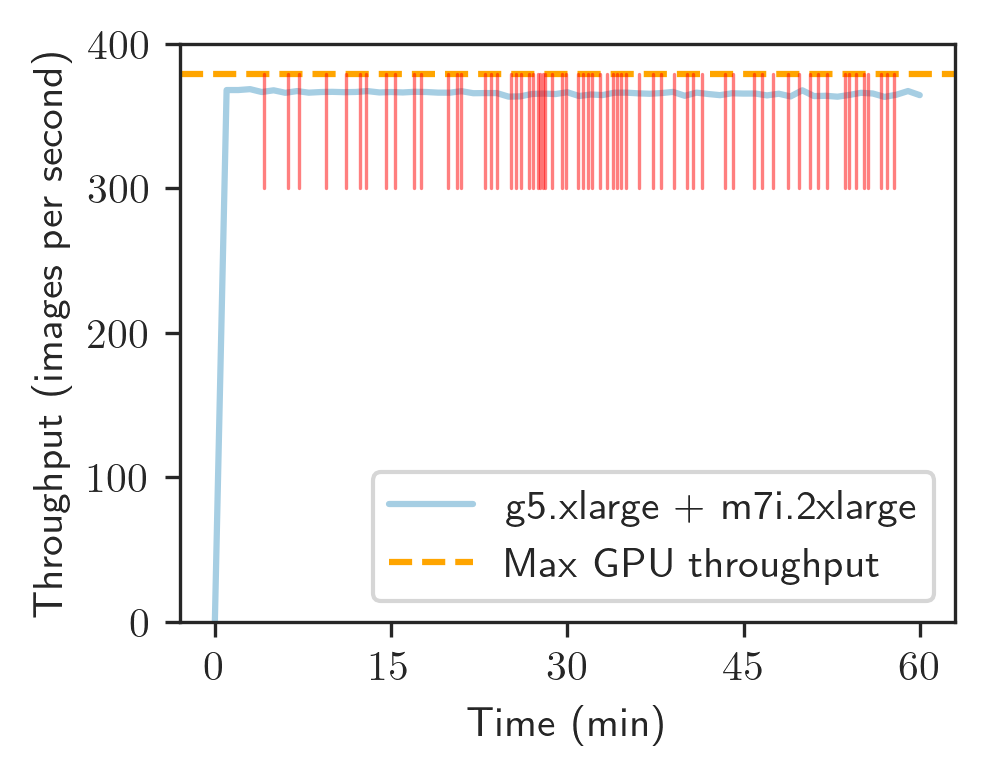

In [16]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 10

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

ax.plot(idx_s3_1_1, values_s3_1_1, label="g5.xlarge + m7i.2xlarge")

ax.axhline(
    y=THEORETICAL_MAX, color="orange", linestyle="--", label="Max GPU throughput"
)

for timestamp in timestamps:
    ax.axvline(x=timestamp, ymin=300/400, ymax=THEORETICAL_MAX/400, color="red", linestyle="-", linewidth=0.8, alpha=0.5)

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.xlabel("Time (min)")
plt.ylabel("Throughput (images per second)")
plt.ylim(0, 400)
plt.legend()
plt.savefig("process-failures.pdf", bbox_inches='tight')